__author__ = 'Ricardo Pasquini'

# Counting tweets at the hexagon level. Complete procedure

Overview: This code counts georeferenced tweets at the hexagon level. Hexagons are uniquely identified in space. We use Uber's H3 library for this purpose.  
The code  also performs a home location prediction for each user. This allows later counting tweets by whether they were tweeted by residents, residents of neighbors hexagons, or non-residents.
The project was designed to be scalable to millions of tweets. The process is done with MongoDB.

By default the project generates the following collections on the Mongo database:

tweets: Collection containing tweets. This collection is modified by incorporating the corresponding hex id. \
users: Collection containing users. This collection is modified by incorporating the home location data.\
hexcounts: Collection containing counts of tweets.


In [40]:
import sys
sys.path.append("../") 
import databasepopulation
import communicationwmongo as commu
import home_location as home
import analysis as a
import pymongo
import pandas as pd
import my_h3_functions as myh3

In [41]:
import importlib
importlib.reload(databasepopulation)
importlib.reload(home)
importlib.reload(a)
importlib.reload(myh3)

<module 'my_h3_functions' from '..\\my_h3_functions.py'>

# Counting tweets at the hexagon level. Complete procedure

This version of the code assumes that a different database will be used for each city.


If necessary check your current location with the following command:

In [42]:
pwd

'C:\\Users\\emman\\Documents\\git\\twitter_and_displacement\\notebooks'

# 0. Connect to Mongo and define a specific database

By default connect to Mongo running on a localhost. 
Requires manually changing the parameters if working on a cloud environment

I will use the name buenosaires as the db example. Recall each database for each city.


In [8]:
db=commu.connecttoLocaldb(database='Twitter_Data')

In [9]:
db.Twitter_Data

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'Twitter_Data'), 'Twitter_Data')

# 1. Raw data to Mongo
This function populates the files containing tweets into Mongo.
Assumes files are named like: ba_2012.csv, etc.
Choose start and end years.


In [7]:
databasepopulation.populatetweets(db, path='/Users/emman/Box/Twitter data/Asia/Sydney/', cityprefix='sydney', yearstart=2012, yearend=2012)

Now populating year  2012
process completed


In [8]:
db.tweets.update({},{'$rename':{"latitude":"lat","longitude":"lon"}}, False,True,True)

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.
  """Entry point for launching an IPython kernel.


{'n': 6043344, 'nModified': 6043344, 'ok': 1.0, 'updatedExisting': True}

# 2. Adding Hexids to tweets 
This function includes hexagons ids to each tweet.  

In [9]:
databasepopulation.addhexjob(db)

 iter: 1  time: 0.6439850330352783
 iter: 2  time: 0.22062468528747559
 iter: 3  time: 0.22016096115112305
 iter: 4  time: 0.24099016189575195
 iter: 5  time: 0.22933197021484375
 iter: 6  time: 0.2373640537261963
 iter: 7  time: 0.2234032154083252
 iter: 8  time: 0.23836135864257812
 iter: 9  time: 0.253328800201416
 iter: 10  time: 0.2854783535003662
 iter: 11  time: 0.242523193359375
 iter: 12  time: 0.23321175575256348
 iter: 13  time: 0.23038315773010254
 iter: 14  time: 0.2642934322357178
 iter: 15  time: 0.24654030799865723
 iter: 16  time: 0.2323775291442871
 iter: 17  time: 0.23635053634643555
 iter: 18  time: 0.28430867195129395
 iter: 19  time: 0.2561221122741699
 iter: 20  time: 0.28822875022888184
 iter: 21  time: 0.303189754486084
 iter: 22  time: 0.39300537109375
 iter: 23  time: 0.3057219982147217
 iter: 24  time: 0.25197291374206543
 iter: 25  time: 0.2537117004394531
 iter: 26  time: 0.3532381057739258
 iter: 27  time: 0.32512879371643066
 iter: 28  time: 0.3121621608

 iter: 223  time: 0.2969658374786377
 iter: 224  time: 0.4479706287384033
 iter: 225  time: 0.439255952835083
 iter: 226  time: 0.6178295612335205
 iter: 227  time: 0.4617652893066406
 iter: 228  time: 0.49866557121276855
 iter: 229  time: 0.4081838130950928
 iter: 230  time: 0.3052692413330078
 iter: 231  time: 0.3236682415008545
 iter: 232  time: 0.3814578056335449
 iter: 233  time: 0.3262031078338623
 iter: 234  time: 0.2962000370025635
 iter: 235  time: 0.306715726852417
 iter: 236  time: 0.370647668838501
 iter: 237  time: 0.3915853500366211
 iter: 238  time: 0.3776082992553711
 iter: 239  time: 0.5294702053070068
 iter: 240  time: 0.3373837471008301
 iter: 241  time: 0.38341379165649414
 iter: 242  time: 0.36902427673339844
 iter: 243  time: 0.3849451541900635
 iter: 244  time: 0.33469414710998535
 iter: 245  time: 0.2999858856201172
 iter: 246  time: 0.3393137454986572
 iter: 247  time: 0.32714247703552246
 iter: 248  time: 0.3451063632965088
 iter: 249  time: 0.3890311717987060

 iter: 443  time: 0.3276371955871582
 iter: 444  time: 0.28717613220214844
 iter: 445  time: 0.28913450241088867
 iter: 446  time: 0.27330780029296875
 iter: 447  time: 0.282839298248291
 iter: 448  time: 0.2613074779510498
 iter: 449  time: 0.2577972412109375
 iter: 450  time: 0.261777400970459
 iter: 451  time: 0.2872638702392578
 iter: 452  time: 0.27564334869384766
 iter: 453  time: 0.30785179138183594
 iter: 454  time: 0.3037407398223877
 iter: 455  time: 0.3387331962585449
 iter: 456  time: 0.33049917221069336
 iter: 457  time: 0.30639052391052246
 iter: 458  time: 0.2763173580169678
 iter: 459  time: 0.2674415111541748
 iter: 460  time: 0.2838249206542969
 iter: 461  time: 0.26117539405822754
 iter: 462  time: 0.2910032272338867
 iter: 463  time: 0.3221592903137207
 iter: 464  time: 0.30518198013305664
 iter: 465  time: 0.3450794219970703
 iter: 466  time: 0.3086221218109131
 iter: 467  time: 0.3303399085998535
 iter: 468  time: 0.30914759635925293
 iter: 469  time: 0.3381655216

 iter: 663  time: 0.3049039840698242
 iter: 664  time: 0.2763700485229492
 iter: 665  time: 0.26534390449523926
 iter: 666  time: 0.26790809631347656
 iter: 667  time: 0.26061153411865234
 iter: 668  time: 0.25842928886413574
 iter: 669  time: 0.26482391357421875
 iter: 670  time: 0.29903149604797363
 iter: 671  time: 0.2835111618041992
 iter: 672  time: 0.27187180519104004
 iter: 673  time: 0.2882838249206543
 iter: 674  time: 0.2808198928833008
 iter: 675  time: 0.27428555488586426
 iter: 676  time: 0.26560139656066895
 iter: 677  time: 0.25748300552368164
 iter: 678  time: 0.2952721118927002
 iter: 679  time: 0.2543354034423828
 iter: 680  time: 0.267392635345459
 iter: 681  time: 0.28423619270324707
 iter: 682  time: 0.296297550201416
 iter: 683  time: 0.27440643310546875
 iter: 684  time: 0.36426758766174316
 iter: 685  time: 0.5046536922454834
 iter: 686  time: 0.40491485595703125
 iter: 687  time: 0.35396838188171387
 iter: 688  time: 0.32836103439331055
 iter: 689  time: 0.2929

 iter: 882  time: 0.32915234565734863
 iter: 883  time: 0.3700103759765625
 iter: 884  time: 0.39394640922546387
 iter: 885  time: 0.31114745140075684
 iter: 886  time: 0.3257873058319092
 iter: 887  time: 0.3604288101196289
 iter: 888  time: 0.2842402458190918
 iter: 889  time: 0.27027392387390137
 iter: 890  time: 0.2703087329864502
 iter: 891  time: 0.26221132278442383
 iter: 892  time: 0.2972428798675537
 iter: 893  time: 0.25232911109924316
 iter: 894  time: 0.2492983341217041
 iter: 895  time: 0.256866455078125
 iter: 896  time: 0.2648732662200928
 iter: 897  time: 0.26334095001220703
 iter: 898  time: 0.25796031951904297
 iter: 899  time: 0.2523970603942871
 iter: 900  time: 0.25136375427246094
 iter: 901  time: 0.29122138023376465
 iter: 902  time: 0.2524423599243164
 iter: 903  time: 0.2403569221496582
 iter: 904  time: 0.24533987045288086
 iter: 905  time: 0.2511451244354248
 iter: 906  time: 0.2552797794342041
 iter: 907  time: 0.24933290481567383
 iter: 908  time: 0.2566285

 iter: 1099  time: 0.3016815185546875
 iter: 1100  time: 0.29117655754089355
 iter: 1101  time: 0.33307528495788574
 iter: 1102  time: 0.29971814155578613
 iter: 1103  time: 0.3050527572631836
 iter: 1104  time: 0.3292548656463623
 iter: 1105  time: 0.33733582496643066
 iter: 1106  time: 0.3141927719116211
 iter: 1107  time: 0.33614087104797363
 iter: 1108  time: 0.2931516170501709
 iter: 1109  time: 0.3037755489349365
 iter: 1110  time: 0.30724477767944336
 iter: 1111  time: 0.30609798431396484
 iter: 1112  time: 0.2805600166320801
 iter: 1113  time: 0.37180590629577637
 iter: 1114  time: 0.32570338249206543
 iter: 1115  time: 0.3219137191772461
 iter: 1116  time: 0.2899787425994873
 iter: 1117  time: 0.2688777446746826
 iter: 1118  time: 0.24140548706054688
 iter: 1119  time: 0.27794647216796875
 iter: 1120  time: 0.7019612789154053
 iter: 1121  time: 0.33510494232177734
 iter: 1122  time: 0.2986183166503906
 iter: 1123  time: 0.3644406795501709
 iter: 1124  time: 0.6800458431243896


 iter: 1313  time: 0.2858579158782959
 iter: 1314  time: 0.25146007537841797
 iter: 1315  time: 0.25859546661376953
 iter: 1316  time: 0.24945712089538574
 iter: 1317  time: 0.23441028594970703
 iter: 1318  time: 0.23633098602294922
 iter: 1319  time: 0.23238897323608398
 iter: 1320  time: 0.27490878105163574
 iter: 1321  time: 0.2649714946746826
 iter: 1322  time: 0.23437809944152832
 iter: 1323  time: 0.25743746757507324
 iter: 1324  time: 0.26978039741516113
 iter: 1325  time: 0.2741520404815674
 iter: 1326  time: 0.25879645347595215
 iter: 1327  time: 0.2549107074737549
 iter: 1328  time: 0.29958486557006836
 iter: 1329  time: 0.2933645248413086
 iter: 1330  time: 0.30222439765930176
 iter: 1331  time: 0.31017303466796875
 iter: 1332  time: 0.3261277675628662
 iter: 1333  time: 0.30576634407043457
 iter: 1334  time: 0.30018019676208496
 iter: 1335  time: 0.2809257507324219
 iter: 1336  time: 0.27265167236328125
 iter: 1337  time: 0.30291318893432617
 iter: 1338  time: 0.28739261627

 iter: 1526  time: 0.2942674160003662
 iter: 1527  time: 0.28499579429626465
 iter: 1528  time: 0.3164255619049072
 iter: 1529  time: 0.2892270088195801
 iter: 1530  time: 0.3032205104827881
 iter: 1531  time: 0.331190824508667
 iter: 1532  time: 0.318157434463501
 iter: 1533  time: 0.3207688331604004
 iter: 1534  time: 0.33038926124572754
 iter: 1535  time: 0.32409095764160156
 iter: 1536  time: 0.3400909900665283
 iter: 1537  time: 0.3343076705932617
 iter: 1538  time: 0.2871420383453369
 iter: 1539  time: 0.27462220191955566
 iter: 1540  time: 0.26689624786376953
 iter: 1541  time: 0.25241637229919434
 iter: 1542  time: 0.2757859230041504
 iter: 1543  time: 0.3002490997314453
 iter: 1544  time: 0.3427908420562744
 iter: 1545  time: 0.30153870582580566
 iter: 1546  time: 0.39183568954467773
 iter: 1547  time: 0.41289639472961426
 iter: 1548  time: 0.3111696243286133
 iter: 1549  time: 0.2962484359741211
 iter: 1550  time: 0.3212571144104004
 iter: 1551  time: 0.39623260498046875
 ite

 iter: 1740  time: 0.38802599906921387
 iter: 1741  time: 0.4428253173828125
 iter: 1742  time: 0.5081171989440918
 iter: 1743  time: 0.5335757732391357
 iter: 1744  time: 0.4957096576690674
 iter: 1745  time: 0.4715158939361572
 iter: 1746  time: 0.5036165714263916
 iter: 1747  time: 0.4524822235107422
 iter: 1748  time: 0.4556601047515869
 iter: 1749  time: 0.4577765464782715
 iter: 1750  time: 0.47983312606811523
 iter: 1751  time: 0.45007777214050293
 iter: 1752  time: 0.4911985397338867
 iter: 1753  time: 0.4777259826660156
 iter: 1754  time: 0.533092737197876
 iter: 1755  time: 0.5026531219482422
 iter: 1756  time: 0.6463284492492676
 iter: 1757  time: 0.4984598159790039
 iter: 1758  time: 0.5176165103912354
 iter: 1759  time: 0.4517967700958252
 iter: 1760  time: 0.41295289993286133
 iter: 1761  time: 0.4034423828125
 iter: 1762  time: 0.4029231071472168
 iter: 1763  time: 0.4118986129760742
 iter: 1764  time: 0.38397979736328125
 iter: 1765  time: 0.4214358329772949
 iter: 1766

 iter: 1954  time: 0.4787485599517822
 iter: 1955  time: 0.4206352233886719
 iter: 1956  time: 0.4159402847290039
 iter: 1957  time: 0.45482301712036133
 iter: 1958  time: 0.3814890384674072
 iter: 1959  time: 0.5176160335540771
 iter: 1960  time: 0.5067238807678223
 iter: 1961  time: 0.5261027812957764
 iter: 1962  time: 0.40189552307128906
 iter: 1963  time: 0.4264044761657715
 iter: 1964  time: 0.391979455947876
 iter: 1965  time: 0.45178723335266113
 iter: 1966  time: 0.4488027095794678
 iter: 1967  time: 0.37302446365356445
 iter: 1968  time: 0.3836956024169922
 iter: 1969  time: 0.3839712142944336
 iter: 1970  time: 0.41046929359436035
 iter: 1971  time: 0.4236316680908203
 iter: 1972  time: 0.4131290912628174
 iter: 1973  time: 0.4966726303100586
 iter: 1974  time: 0.4089047908782959
 iter: 1975  time: 0.3968179225921631
 iter: 1976  time: 0.37001705169677734
 iter: 1977  time: 0.37898755073547363
 iter: 1978  time: 0.38386988639831543
 iter: 1979  time: 0.3770270347595215
 iter

 iter: 2168  time: 0.40894365310668945
 iter: 2169  time: 0.39493417739868164
 iter: 2170  time: 0.41244006156921387
 iter: 2171  time: 0.44200706481933594
 iter: 2172  time: 0.3935883045196533
 iter: 2173  time: 0.41792798042297363
 iter: 2174  time: 0.4089057445526123
 iter: 2175  time: 0.4278566837310791
 iter: 2176  time: 0.4039597511291504
 iter: 2177  time: 0.4035916328430176
 iter: 2178  time: 0.41289234161376953
 iter: 2179  time: 0.464245080947876
 iter: 2180  time: 0.4828348159790039
 iter: 2181  time: 0.5699896812438965
 iter: 2182  time: 0.5076723098754883
 iter: 2183  time: 0.5315163135528564
 iter: 2184  time: 0.6707158088684082
 iter: 2185  time: 0.5749759674072266
 iter: 2186  time: 0.5226364135742188
 iter: 2187  time: 0.6333048343658447
 iter: 2188  time: 0.5881071090698242
 iter: 2189  time: 0.5729036331176758
 iter: 2190  time: 0.5076456069946289
 iter: 2191  time: 0.4273710250854492
 iter: 2192  time: 0.44440531730651855
 iter: 2193  time: 0.425443172454834
 iter: 

 iter: 2383  time: 0.3909578323364258
 iter: 2384  time: 0.43283963203430176
 iter: 2385  time: 0.39498257637023926
 iter: 2386  time: 0.4488534927368164
 iter: 2387  time: 0.43480658531188965
 iter: 2388  time: 0.4941976070404053
 iter: 2389  time: 0.4672670364379883
 iter: 2390  time: 0.5166149139404297
 iter: 2391  time: 0.45792508125305176
 iter: 2392  time: 0.7403435707092285
 iter: 2393  time: 0.5390338897705078
 iter: 2394  time: 0.5391056537628174
 iter: 2395  time: 0.5182337760925293
 iter: 2396  time: 0.5967261791229248
 iter: 2397  time: 0.5442600250244141
 iter: 2398  time: 0.4637298583984375
 iter: 2399  time: 0.4952254295349121
 iter: 2400  time: 0.47115635871887207
 iter: 2401  time: 0.44081687927246094
 iter: 2402  time: 0.47730565071105957
 iter: 2403  time: 0.4239380359649658
 iter: 2404  time: 0.4375433921813965
 iter: 2405  time: 0.4442610740661621
 iter: 2406  time: 0.427858829498291
 iter: 2407  time: 0.45516133308410645
 iter: 2408  time: 0.4491300582885742
 iter

 iter: 2597  time: 0.4331061840057373
 iter: 2598  time: 0.4696488380432129
 iter: 2599  time: 0.5176517963409424
 iter: 2600  time: 0.5704963207244873
 iter: 2601  time: 0.4742436408996582
 iter: 2602  time: 0.41758036613464355
 iter: 2603  time: 0.49217891693115234
 iter: 2604  time: 0.48669886589050293
 iter: 2605  time: 0.4687371253967285
 iter: 2606  time: 0.41440582275390625
 iter: 2607  time: 0.45079493522644043
 iter: 2608  time: 0.4718470573425293
 iter: 2609  time: 0.43187785148620605
 iter: 2610  time: 0.43453288078308105
 iter: 2611  time: 0.3919668197631836
 iter: 2612  time: 0.4313995838165283
 iter: 2613  time: 0.44831252098083496
 iter: 2614  time: 0.43781423568725586
 iter: 2615  time: 0.4228684902191162
 iter: 2616  time: 0.4378981590270996
 iter: 2617  time: 0.45181727409362793
 iter: 2618  time: 0.4682338237762451
 iter: 2619  time: 0.4468038082122803
 iter: 2620  time: 0.41201186180114746
 iter: 2621  time: 0.4324455261230469
 iter: 2622  time: 0.4252002239227295
 

 iter: 2811  time: 0.38950204849243164
 iter: 2812  time: 0.4497950077056885
 iter: 2813  time: 0.38926267623901367
 iter: 2814  time: 0.39098310470581055
 iter: 2815  time: 0.4264359474182129
 iter: 2816  time: 0.37897276878356934
 iter: 2817  time: 0.4154021739959717
 iter: 2818  time: 0.3837265968322754
 iter: 2819  time: 0.36420130729675293
 iter: 2820  time: 0.38695740699768066
 iter: 2821  time: 0.3873269557952881
 iter: 2822  time: 0.3829483985900879
 iter: 2823  time: 0.3973729610443115
 iter: 2824  time: 0.35582470893859863
 iter: 2825  time: 0.3779616355895996
 iter: 2826  time: 0.3790147304534912
 iter: 2827  time: 0.38274598121643066
 iter: 2828  time: 0.42040467262268066
 iter: 2829  time: 0.3925211429595947
 iter: 2830  time: 0.39902591705322266
 iter: 2831  time: 0.42087340354919434
 iter: 2832  time: 0.3675668239593506
 iter: 2833  time: 0.3795313835144043
 iter: 2834  time: 0.3550255298614502
 iter: 2835  time: 0.3974137306213379
 iter: 2836  time: 0.38872575759887695


 iter: 3026  time: 0.3944404125213623
 iter: 3027  time: 0.39095377922058105
 iter: 3028  time: 0.40552496910095215
 iter: 3029  time: 0.4438974857330322
 iter: 3030  time: 0.4338405132293701
 iter: 3031  time: 0.3949429988861084
 iter: 3032  time: 0.3684415817260742
 iter: 3033  time: 0.3685038089752197
 iter: 3034  time: 0.3893930912017822
 iter: 3035  time: 0.3869929313659668
 iter: 3036  time: 0.4117434024810791
 iter: 3037  time: 0.45130133628845215
 iter: 3038  time: 0.3885059356689453
 iter: 3039  time: 0.3769187927246094
 iter: 3040  time: 0.3815889358520508
 iter: 3041  time: 0.40900230407714844
 iter: 3042  time: 0.3859670162200928
 iter: 3043  time: 0.4298393726348877
 iter: 3044  time: 0.38277244567871094
 iter: 3045  time: 0.38564372062683105
 iter: 3046  time: 0.4114096164703369
 iter: 3047  time: 0.37305188179016113
 iter: 3048  time: 0.36658310890197754
 iter: 3049  time: 0.3923337459564209
 iter: 3050  time: 0.38197994232177734
 iter: 3051  time: 0.3840479850769043
 it

 iter: 3240  time: 0.42096686363220215
 iter: 3241  time: 0.40389418601989746
 iter: 3242  time: 0.3989601135253906
 iter: 3243  time: 0.39426493644714355
 iter: 3244  time: 0.4356958866119385
 iter: 3245  time: 0.4164741039276123
 iter: 3246  time: 0.4040336608886719
 iter: 3247  time: 0.38942790031433105
 iter: 3248  time: 0.40433216094970703
 iter: 3249  time: 0.41588759422302246
 iter: 3250  time: 0.4089336395263672
 iter: 3251  time: 0.44032716751098633
 iter: 3252  time: 0.4517676830291748
 iter: 3253  time: 0.4179103374481201
 iter: 3254  time: 0.4384946823120117
 iter: 3255  time: 0.4420647621154785
 iter: 3256  time: 0.4346764087677002
 iter: 3257  time: 0.45378661155700684
 iter: 3258  time: 0.4471430778503418
 iter: 3259  time: 0.43936634063720703
 iter: 3260  time: 0.43365025520324707
 iter: 3261  time: 0.4092590808868408
 iter: 3262  time: 0.45883965492248535
 iter: 3263  time: 0.5804891586303711
 iter: 3264  time: 0.4727344512939453
 iter: 3265  time: 0.42998194694519043


 iter: 3454  time: 0.4118983745574951
 iter: 3455  time: 0.4503457546234131
 iter: 3456  time: 0.4921419620513916
 iter: 3457  time: 0.43398499488830566
 iter: 3458  time: 0.486234188079834
 iter: 3459  time: 0.4128682613372803
 iter: 3460  time: 0.4598121643066406
 iter: 3461  time: 0.4144296646118164
 iter: 3462  time: 0.41489195823669434
 iter: 3463  time: 0.40546703338623047
 iter: 3464  time: 0.40790295600891113
 iter: 3465  time: 0.43143439292907715
 iter: 3466  time: 0.5166118144989014
 iter: 3467  time: 0.4905693531036377
 iter: 3468  time: 0.4713404178619385
 iter: 3469  time: 0.4218757152557373
 iter: 3470  time: 0.4209582805633545
 iter: 3471  time: 0.47181272506713867
 iter: 3472  time: 0.412585973739624
 iter: 3473  time: 0.4916810989379883
 iter: 3474  time: 0.41656947135925293
 iter: 3475  time: 0.44884681701660156
 iter: 3476  time: 0.4072713851928711
 iter: 3477  time: 0.4189610481262207
 iter: 3478  time: 0.39992833137512207
 iter: 3479  time: 0.40950536727905273
 ite

 iter: 3669  time: 0.4029226303100586
 iter: 3670  time: 0.42084431648254395
 iter: 3671  time: 0.41991400718688965
 iter: 3672  time: 0.4303569793701172
 iter: 3673  time: 0.45330333709716797
 iter: 3674  time: 0.4109010696411133
 iter: 3675  time: 0.4222757816314697
 iter: 3676  time: 0.42836713790893555
 iter: 3677  time: 0.4298207759857178
 iter: 3678  time: 0.44945192337036133
 iter: 3679  time: 0.45133495330810547
 iter: 3680  time: 0.4368312358856201
 iter: 3681  time: 0.45282888412475586
 iter: 3682  time: 0.44498753547668457
 iter: 3683  time: 0.4515519142150879
 iter: 3684  time: 0.4448089599609375
 iter: 3685  time: 0.40393900871276855
 iter: 3686  time: 0.45778560638427734
 iter: 3687  time: 0.4418454170227051
 iter: 3688  time: 0.4096243381500244
 iter: 3689  time: 0.4933595657348633
 iter: 3690  time: 0.43782925605773926
 iter: 3691  time: 0.4228682518005371
 iter: 3692  time: 0.3959789276123047
 iter: 3693  time: 0.42131948471069336
 iter: 3694  time: 0.4234178066253662


 iter: 3884  time: 0.4523000717163086
 iter: 3885  time: 0.45284605026245117
 iter: 3886  time: 0.48224306106567383
 iter: 3887  time: 0.4999682903289795
 iter: 3888  time: 0.496213436126709
 iter: 3889  time: 0.5061931610107422
 iter: 3890  time: 0.44120311737060547
 iter: 3891  time: 0.4617350101470947
 iter: 3892  time: 0.44258594512939453
 iter: 3893  time: 0.4582860469818115
 iter: 3894  time: 0.457805871963501
 iter: 3895  time: 0.4987335205078125
 iter: 3896  time: 0.4188859462738037
 iter: 3897  time: 0.4169135093688965
 iter: 3898  time: 0.4387969970703125
 iter: 3899  time: 0.416919469833374
 iter: 3900  time: 0.45781445503234863
 iter: 3901  time: 0.45179319381713867
 iter: 3902  time: 0.45798563957214355
 iter: 3903  time: 0.45151662826538086
 iter: 3904  time: 0.4916877746582031
 iter: 3905  time: 0.4258913993835449
 iter: 3906  time: 0.45523905754089355
 iter: 3907  time: 0.5178637504577637
 iter: 3908  time: 0.5206418037414551
 iter: 3909  time: 0.48842382431030273
 iter

 iter: 4098  time: 0.4378659725189209
 iter: 4099  time: 0.4926893711090088
 iter: 4100  time: 0.44635462760925293
 iter: 4101  time: 0.4667520523071289
 iter: 4102  time: 0.4613523483276367
 iter: 4103  time: 0.4864497184753418
 iter: 4104  time: 0.46131181716918945
 iter: 4105  time: 0.4577763080596924
 iter: 4106  time: 0.4448239803314209
 iter: 4107  time: 0.4242393970489502
 iter: 4108  time: 0.41831398010253906
 iter: 4109  time: 0.4134202003479004
 iter: 4110  time: 0.4757266044616699
 iter: 4111  time: 0.4140441417694092
 iter: 4112  time: 0.44892191886901855
 iter: 4113  time: 0.47473573684692383
 iter: 4114  time: 0.5272760391235352
 iter: 4115  time: 0.4597795009613037
 iter: 4116  time: 0.5390746593475342
 iter: 4117  time: 0.4727351665496826
 iter: 4118  time: 0.5215497016906738
 iter: 4119  time: 0.4812490940093994
 iter: 4120  time: 0.48047876358032227
 iter: 4121  time: 0.4323720932006836
 iter: 4122  time: 0.4433462619781494
 iter: 4123  time: 0.4607870578765869
 iter:

 iter: 4312  time: 0.4009273052215576
 iter: 4313  time: 0.5206434726715088
 iter: 4314  time: 0.6397593021392822
 iter: 4315  time: 0.47373533248901367
 iter: 4316  time: 0.47396016120910645
 iter: 4317  time: 0.4041416645050049
 iter: 4318  time: 0.4001023769378662
 iter: 4319  time: 0.4059429168701172
 iter: 4320  time: 0.4288761615753174
 iter: 4321  time: 0.4663429260253906
 iter: 4322  time: 0.466749906539917
 iter: 4323  time: 0.4967052936553955
 iter: 4324  time: 0.44892334938049316
 iter: 4325  time: 0.42510294914245605
 iter: 4326  time: 0.3934621810913086
 iter: 4327  time: 0.4039182662963867
 iter: 4328  time: 0.40293025970458984
 iter: 4329  time: 0.4276425838470459
 iter: 4330  time: 0.44506096839904785
 iter: 4331  time: 0.4617600440979004
 iter: 4332  time: 0.4613163471221924
 iter: 4333  time: 0.4945714473724365
 iter: 4334  time: 0.4497647285461426
 iter: 4335  time: 0.44812583923339844
 iter: 4336  time: 0.46811866760253906
 iter: 4337  time: 0.6702060699462891
 iter

 iter: 4526  time: 0.4623088836669922
 iter: 4527  time: 0.44580817222595215
 iter: 4528  time: 0.46376633644104004
 iter: 4529  time: 0.46977663040161133
 iter: 4530  time: 0.5381209850311279
 iter: 4531  time: 0.5330710411071777
 iter: 4532  time: 0.45478320121765137
 iter: 4533  time: 0.4274294376373291
 iter: 4534  time: 0.4224398136138916
 iter: 4535  time: 0.45820116996765137
 iter: 4536  time: 0.7001276016235352
 iter: 4537  time: 0.6193623542785645
 iter: 4538  time: 0.6133589744567871
 iter: 4539  time: 0.6777868270874023
 iter: 4540  time: 0.6707217693328857
 iter: 4541  time: 0.5901110172271729
 iter: 4542  time: 0.5380825996398926
 iter: 4543  time: 0.5081841945648193
 iter: 4544  time: 0.5116825103759766
 iter: 4545  time: 0.6031255722045898
 iter: 4546  time: 0.5750067234039307
 iter: 4547  time: 0.8146135807037354
 iter: 4548  time: 0.7155129909515381
 iter: 4549  time: 0.7729341983795166
 iter: 4550  time: 0.7161557674407959
 iter: 4551  time: 0.6716642379760742
 iter: 

 iter: 4740  time: 0.43135929107666016
 iter: 4741  time: 0.4325282573699951
 iter: 4742  time: 0.4084465503692627
 iter: 4743  time: 0.41690969467163086
 iter: 4744  time: 0.45017099380493164
 iter: 4745  time: 0.4919548034667969
 iter: 4746  time: 0.49193692207336426
 iter: 4747  time: 0.4578573703765869
 iter: 4748  time: 0.4611790180206299
 iter: 4749  time: 0.46379804611206055
 iter: 4750  time: 0.4467751979827881
 iter: 4751  time: 0.461439847946167
 iter: 4752  time: 0.4341237545013428
 iter: 4753  time: 0.4682581424713135
 iter: 4754  time: 0.43483877182006836
 iter: 4755  time: 0.4518272876739502
 iter: 4756  time: 0.5297513008117676
 iter: 4757  time: 0.48470354080200195
 iter: 4758  time: 0.48336267471313477
 iter: 4759  time: 0.5126664638519287
 iter: 4760  time: 0.5515255928039551
 iter: 4761  time: 0.49285244941711426
 iter: 4762  time: 0.5487244129180908
 iter: 4763  time: 0.4856998920440674
 iter: 4764  time: 0.4399538040161133
 iter: 4765  time: 0.462843656539917
 iter

 iter: 4955  time: 0.4244112968444824
 iter: 4956  time: 0.4438142776489258
 iter: 4957  time: 0.41588401794433594
 iter: 4958  time: 0.4154365062713623
 iter: 4959  time: 0.439852237701416
 iter: 4960  time: 0.4588127136230469
 iter: 4961  time: 0.4332897663116455
 iter: 4962  time: 0.42586231231689453
 iter: 4963  time: 0.43889737129211426
 iter: 4964  time: 0.4086465835571289
 iter: 4965  time: 0.42711663246154785
 iter: 4966  time: 0.48374438285827637
 iter: 4967  time: 0.5036442279815674
 iter: 4968  time: 0.536128044128418
 iter: 4969  time: 0.4313318729400635
 iter: 4970  time: 0.4388253688812256
 iter: 4971  time: 0.4439258575439453
 iter: 4972  time: 0.4517703056335449
 iter: 4973  time: 0.4029240608215332
 iter: 4974  time: 0.4278550148010254
 iter: 4975  time: 0.49898362159729004
 iter: 4976  time: 0.5729560852050781
 iter: 4977  time: 0.5505692958831787
 iter: 4978  time: 0.4862556457519531
 iter: 4979  time: 0.43036389350891113
 iter: 4980  time: 0.4028935432434082
 iter: 

 iter: 5170  time: 0.4259035587310791
 iter: 5171  time: 0.4297051429748535
 iter: 5172  time: 0.4827084541320801
 iter: 5173  time: 0.44305920600891113
 iter: 5174  time: 0.5203676223754883
 iter: 5175  time: 0.4185192584991455
 iter: 5176  time: 0.4388291835784912
 iter: 5177  time: 0.40966200828552246
 iter: 5178  time: 0.42835211753845215
 iter: 5179  time: 0.4122731685638428
 iter: 5180  time: 0.4497678279876709
 iter: 5181  time: 0.5382370948791504
 iter: 5182  time: 0.6863172054290771
 iter: 5183  time: 0.5016567707061768
 iter: 5184  time: 0.45540833473205566
 iter: 5185  time: 0.47578930854797363
 iter: 5186  time: 0.46276164054870605
 iter: 5187  time: 0.4161391258239746
 iter: 5188  time: 0.4449160099029541
 iter: 5189  time: 0.6007430553436279
 iter: 5190  time: 0.6103987693786621
 iter: 5191  time: 0.6835780143737793
 iter: 5192  time: 0.5520639419555664
 iter: 5193  time: 0.4782259464263916
 iter: 5194  time: 0.45674610137939453
 iter: 5195  time: 0.41027212142944336
 ite

 iter: 5384  time: 0.48171162605285645
 iter: 5385  time: 0.4684443473815918
 iter: 5386  time: 0.4417588710784912
 iter: 5387  time: 0.4062232971191406
 iter: 5388  time: 0.4418153762817383
 iter: 5389  time: 0.5000035762786865
 iter: 5390  time: 0.44991636276245117
 iter: 5391  time: 0.46177220344543457
 iter: 5392  time: 0.434833288192749
 iter: 5393  time: 0.4303877353668213
 iter: 5394  time: 0.4120938777923584
 iter: 5395  time: 0.46774911880493164
 iter: 5396  time: 0.42836976051330566
 iter: 5397  time: 0.5205128192901611
 iter: 5398  time: 0.4258906841278076
 iter: 5399  time: 0.4598078727722168
 iter: 5400  time: 0.4363555908203125
 iter: 5401  time: 0.47424864768981934
 iter: 5402  time: 0.5016932487487793
 iter: 5403  time: 0.44054579734802246
 iter: 5404  time: 0.45381665229797363
 iter: 5405  time: 0.47324275970458984
 iter: 5406  time: 0.4364476203918457
 iter: 5407  time: 0.44013142585754395
 iter: 5408  time: 0.4507448673248291
 iter: 5409  time: 0.426347017288208
 ite

 iter: 5598  time: 0.4530673027038574
 iter: 5599  time: 0.4323272705078125
 iter: 5600  time: 0.4805448055267334
 iter: 5601  time: 0.5271024703979492
 iter: 5602  time: 0.5046529769897461
 iter: 5603  time: 0.5119390487670898
 iter: 5604  time: 0.4898502826690674
 iter: 5605  time: 0.4812452793121338
 iter: 5606  time: 0.4764821529388428
 iter: 5607  time: 0.45190954208374023
 iter: 5608  time: 0.4323580265045166
 iter: 5609  time: 0.46575403213500977
 iter: 5610  time: 0.47733473777770996
 iter: 5611  time: 0.4759337902069092
 iter: 5612  time: 0.4677577018737793
 iter: 5613  time: 0.45163726806640625
 iter: 5614  time: 0.44284939765930176
 iter: 5615  time: 0.4269134998321533
 iter: 5616  time: 0.44876980781555176
 iter: 5617  time: 0.44467639923095703
 iter: 5618  time: 0.45232343673706055
 iter: 5619  time: 0.4408242702484131
 iter: 5620  time: 0.4862344264984131
 iter: 5621  time: 0.43767333030700684
 iter: 5622  time: 0.45592284202575684
 iter: 5623  time: 0.4448397159576416
 i

 iter: 5813  time: 0.48107147216796875
 iter: 5814  time: 0.4877030849456787
 iter: 5815  time: 0.5231149196624756
 iter: 5816  time: 0.6298279762268066
 iter: 5817  time: 0.5311334133148193
 iter: 5818  time: 0.5495645999908447
 iter: 5819  time: 0.4860706329345703
 iter: 5820  time: 0.5091581344604492
 iter: 5821  time: 0.4713151454925537
 iter: 5822  time: 0.469836950302124
 iter: 5823  time: 0.5113303661346436
 iter: 5824  time: 0.4764823913574219
 iter: 5825  time: 0.46740078926086426
 iter: 5826  time: 0.5418562889099121
 iter: 5827  time: 0.5053002834320068
 iter: 5828  time: 0.49068760871887207
 iter: 5829  time: 0.44435763359069824
 iter: 5830  time: 0.44570064544677734
 iter: 5831  time: 0.4332091808319092
 iter: 5832  time: 0.416884183883667
 iter: 5833  time: 0.41643762588500977
 iter: 5834  time: 0.49714231491088867
 iter: 5835  time: 0.4433910846710205
 iter: 5836  time: 0.42087292671203613
 iter: 5837  time: 0.4514033794403076
 iter: 5838  time: 0.45636439323425293
 iter

 iter: 6028  time: 0.5663111209869385
 iter: 6029  time: 0.5745162963867188
 iter: 6030  time: 0.5505280494689941
 iter: 6031  time: 0.5402581691741943
 iter: 6032  time: 0.5993690490722656
 iter: 6033  time: 0.5469458103179932
 iter: 6034  time: 0.5812249183654785
 iter: 6035  time: 0.4817781448364258
 iter: 6036  time: 0.476421594619751
 iter: 6037  time: 0.42398667335510254
 iter: 6038  time: 0.4527890682220459
 iter: 6039  time: 0.46651530265808105
 iter: 6040  time: 0.4857032299041748
 iter: 6041  time: 0.44167351722717285
 iter: 6042  time: 0.5196146965026855
 iter: 6043  time: 0.48175930976867676
total elapsed time: 2597.4199578762054


In [10]:
# the following is a check and a fix because I think the previous process did not run completely, probably a bug.
# are there any other documents that were not processed?
len(list(db.tweets.find({ "hex" : { "$exists" : False } })))

344

In [11]:
#Process any missing document
cursor=db.tweets.find({ "hex" : { "$exists" : False } })
df = pd.DataFrame(list(cursor))
requests = databasepopulation.add_hexs_and_prepare_bulk_request(df, dataformat='raw')
try:
    db.tweets.bulk_write(requests, ordered=False)
except BulkWriteError as bwe:
    print(bwe.details)

# 3. Database performance task: Add indexes to tweets

In [12]:
databasepopulation.create_indexes(db)

# 4. Populate Users Collection

In [13]:
databasepopulation.populate_users_collection(db)

# 5. Find Home Job for each user id in the database

In [45]:
print('Users with home location identified', db.users.count_documents({'hex9': { '$exists': True} }))


Users with home location identified 19441


# 6 Generate a Hex-level collection including all hexs in the database

By default the collection include as ids only the ids of hexagons at resolution 9
Note that many types of hexogons could coexist in a same collection because hex identifiers are unique. This is not implemented in the current version of the code, though.

In [47]:
databasepopulation.populate_hexcounts_collection(db)

# 7 Count tweets in each hex by residents and non-residents

In [39]:
import analysis as a

In [70]:
#a.countandpopulatejob(db)

Hexagons pending to analyze.. 17157
iter: 50
iter: 100
iter: 150
iter: 200
iter: 250
iter: 300
iter: 350
iter: 400
iter: 450
iter: 500
iter: 550
iter: 600
iter: 650
iter: 700
iter: 750
iter: 800
iter: 850
iter: 900
iter: 950
iter: 1000
iter: 1050
iter: 1100
iter: 1150
iter: 1200
iter: 1250
iter: 1300
iter: 1350
iter: 1400
iter: 1450
iter: 1500
iter: 1550
iter: 1600
iter: 1650
iter: 1700
iter: 1750
iter: 1800
iter: 1850
iter: 1900
iter: 1950
iter: 2000
iter: 2050
iter: 2100
iter: 2150
iter: 2200
iter: 2250
iter: 2300
iter: 2350
iter: 2400
iter: 2450
iter: 2500
iter: 2550
iter: 2600
iter: 2650
iter: 2700
iter: 2750
iter: 2800
iter: 2850
iter: 2900
iter: 2950
iter: 3000
iter: 3050
iter: 3100
iter: 3150
iter: 3200
iter: 3250
iter: 3300
iter: 3350
iter: 3400
iter: 3450
iter: 3500
iter: 3550
iter: 3600
iter: 3650
iter: 3700
iter: 3750
iter: 3800
iter: 3850
iter: 3900
iter: 3950
iter: 4000
iter: 4050
iter: 4100
iter: 4150
iter: 4200
iter: 4250
iter: 4300
iter: 4350
iter: 4400
iter: 4450
iter:

# 8 Query to the DB to create the counts dataframe 

In [43]:
import time 
start=time.time()
df=a.hexcountsresults_to_df(db, save=False)
print(time.time()-start)
# if save=True then saves resulting dataframe a pickle in ./hexcountsdf.pkl

2.10823655128479


In [46]:
def rotate_hex_coordinates(hexid):
    inv_coordinates=h3.h3_to_geo(hexid)
    return h3.geo_to_h3(inv_coordinates[1],inv_coordinates[0],9)

from h3 import h3
df['_id']=df['_id'].apply(lambda row:  rotate_hex_coordinates(row))
df.head()

,_id,level_1,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,time,geometry
0,894ed85084bffff,1404086400000,1.0,1.0,NaN,1.0,2014-06-30,"POLYGON ((-33.985 150.654, -33.983 150.653, -3..."
1,894ed85092bffff,1380499200000,1.0,1.0,NaN,1.0,2013-09-30,"POLYGON ((-34.023 150.661, -34.021 150.661, -3..."
2,894ed850d6fffff,1419984000000,2.0,2.0,NaN,2.0,2014-12-31,"POLYGON ((-34.006 150.672, -34.004 150.671, -3..."
3,894ed851da3ffff,1435622400000,2.0,2.0,NaN,2.0,2015-06-30,"POLYGON ((-33.968 150.645, -33.966 150.645, -3..."
4,894ed8500b3ffff,1356912000000,3.0,3.0,NaN,3.0,2012-12-31,"POLYGON ((-33.931 150.683, -33.929 150.682, -3..."


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206078 entries, 0 to 206077
Data columns (total 8 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   _id                          206078 non-null  object        
 1   level_1                      206078 non-null  object        
 2   nonresidents                 204800 non-null  float64       
 3   nonresidentsandnonneighbors  203578 non-null  float64       
 4   residents                    32190 non-null   float64       
 5   totalcounts                  206078 non-null  float64       
 6   time                         206078 non-null  datetime64[ns]
 7   geometry                     206078 non-null  geometry      
dtypes: datetime64[ns](1), float64(4), geometry(1), object(2)
memory usage: 14.2+ MB


In [48]:
#df.to_csv('C:/Users/Emman/Desktop/Sydney_Hexes_RP.csv')

# Funcions for Spatial Analysis
### A. Transform the dataframe with hexids into a geodataframe with hexagons as geometries

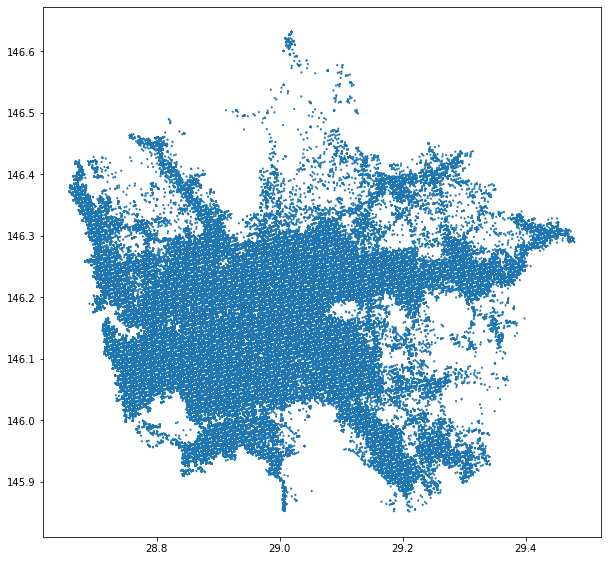

In [49]:
hexgdf = myh3.df_with_hexid_to_gdf(df, hexcolname='_id')
hexgdf.plot()

In [38]:
hexgdf.head()

,_id,level_1,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,time,geometry
0,894ed85084bffff,1404086400000,1.0,1.0,NaN,1.0,2014-06-30,"POLYGON ((29.349 146.017, 29.350 146.017, 29.3..."
1,894ed85092bffff,1380499200000,1.0,1.0,NaN,1.0,2013-09-30,"POLYGON ((29.340 145.978, 29.342 145.978, 29.3..."
2,894ed850d6fffff,1419984000000,2.0,2.0,NaN,2.0,2014-12-31,"POLYGON ((29.328 145.997, 29.330 145.996, 29.3..."
3,894ed851da3ffff,1435622400000,2.0,2.0,NaN,2.0,2015-06-30,"POLYGON ((29.357 146.036, 29.359 146.036, 29.3..."
4,894ed8500b3ffff,1356912000000,3.0,3.0,NaN,3.0,2012-12-31,"POLYGON ((29.320 146.071, 29.322 146.071, 29.3..."


## B. Transform the dataframe with hexids into a geodataframe with centoids points as geometries

#### Points can be used for spatial joins.

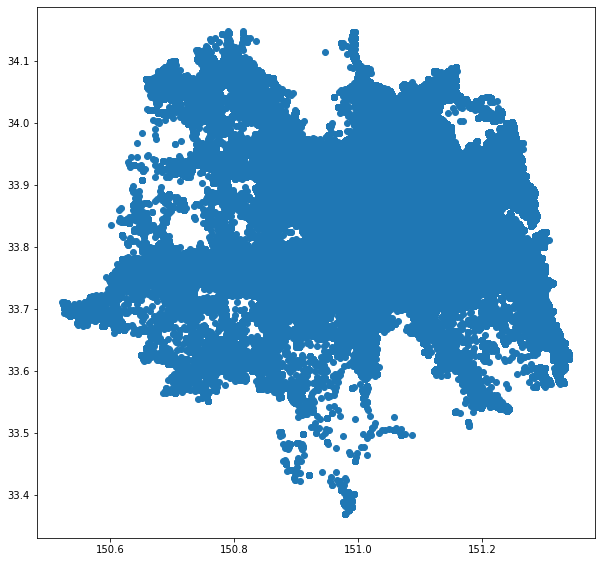

In [41]:
centroidsgdf = myh3.df_with_hexid_to_centroids_gdf(hexgdf, hexcolname='_id')
centroidsgdf.rotate(270, origin = (0,0), use_radians=False).plot()

In [ ]:
smooth_hexgdf = myh3.kring_smoother(hexgdf, hexcolname='_id',  metric_col='nonresidents')

In [48]:
smooth_hexgdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 28532 entries, 0 to 28531
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   _id           28532 non-null  object  
 1   nonresidents  28532 non-null  float64 
 2   lat           28532 non-null  float64 
 3   lng           28532 non-null  float64 
 4   geometry      28532 non-null  geometry
dtypes: float64(3), geometry(1), object(1)
memory usage: 1.1+ MB


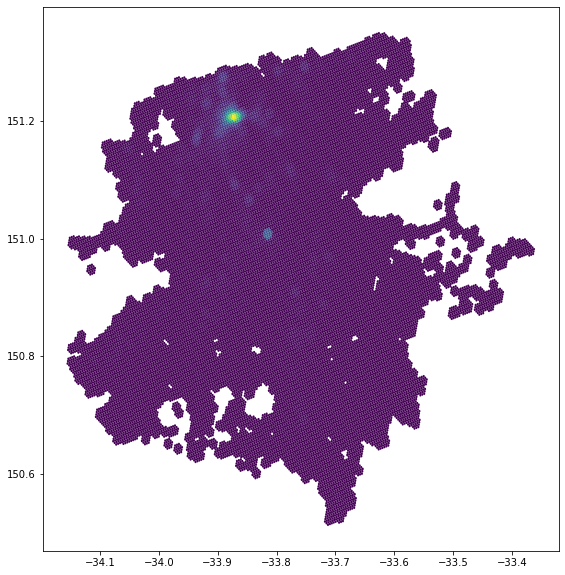

In [50]:
smooth_hexgdf.plot(column='nonresidents')